# Stanford CME 241 (Winter 2026) - Assignment 1

**Due: Friday, January 23 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/onat-dalmaz/RL-book/blob/main/assignment1.ipynb

*Group members (replace below names with people in your group):*
- Onat Dalmaz


## Imports

In [1]:
from __future__ import annotations

from typing import Dict, Mapping, List, Tuple
import numpy as np
import matplotlib.pyplot as plt

# RL-book imports (installed via Assignment 0). If these fail, ensure you activated the same venv.
from rl.distribution import Categorical, Constant
from rl.markov_process import FiniteMarkovProcess, NonTerminal, Terminal


## Question 1: Snakes and Ladders

In the classic childhood game of Snakes and Ladders, all players start to the left of square 1 (call this position 0) and roll a 6-sided die to represent the number of squares they can move forward. The goal is to reach square 100 as quickly as possible. Landing on the bottom rung of a ladder allows for an automatic free-pass to climb, e.g. square 4 sends you directly to 14; whereas landing on a snake's head forces one to slide all the way to the tail, e.g. square 34 sends you to 6. Note, this game can be viewed as a Markov Process, where the outcome is only depedent on the current state and not the prior trajectory. In this question, we will ask you to both formally describe the Markov Process that describes this game, followed by coding up a version of the game to get familiar with the RL-book libraries.


### Problem Statement

How can we model this problem with a Markov Process?

---

### Subquestions

#### Part (A): MDP Modeling

Formalize the state space of the Snakes and Ladders game. Don't forget to specify the terminal state!

---

#### Part (B): Transition Probabilities

Write out the structure of the transition probabilities. Feel free to abbreviate all squares that do not have a snake or ladder.

---

#### Part (C): Modeling the Game

Code up a `transition_map: Transition[S]` data structure to represent the transition probabilities of the Snakes and Ladders Markov Process so you can model the game as an instance of `FiniteMarkovProcess`. Use the `traces` method to create sampling traces, and plot the graph of the distribution of time steps to finish the game. Use the image provided for the locations of the snakes and ladders.

https://drive.google.com/file/d/1yhP242sG092Ico\_WOPKrUp8jVJHbuGHH/view?usp=sharing

---

### Part (A) Answer

A convenient Markov Process model uses one state per board position.

- **State space**: $S = \{0,1,2,\ldots,100\}$, where state $s$ means "the token is on square $s$".
- **Terminal state**: $100$ is terminal (absorbing): once you reach square 100, the game ends.

To incorporate snakes/ladders, define a deterministic "jump" function $J:\{0,\ldots,100\}\to\{0,\ldots,100\}$ that maps
a square to its post-jump destination (identity on ordinary squares, head->tail for snakes, bottom->top for ladders).
Then the one-step evolution is: roll a die $D\in\{1,\ldots,6\}$, move to $\min(100, s + D)$, then apply $J$.


### Part (B) Answer

Let $D\sim\text{Unif}\{1,2,3,4,5,6\}$. For any non-terminal square $s\in\{0,\ldots,99\}$, define

$$
s' = J\big(\min(100, s + D)\big).
$$

Then the transition probabilities are

$$
\mathbb P[X_{t+1}=x\mid X_t=s]
= \frac{1}{6}\,\big|\{d\in\{1,\ldots,6\}: J(\min(100,s+d)) = x\}\big|.
$$

For the terminal state:

$$
\mathbb P[X_{t+1}=100\mid X_t=100] = 1.
$$

Equivalently: **each die face contributes probability $1/6$** to the single next square produced by "move then jump".
Squares without snakes/ladders simply have $J(u)=u$.


### Part (C) Answer

samples=30000  mean=35.79  median=29  p90=66


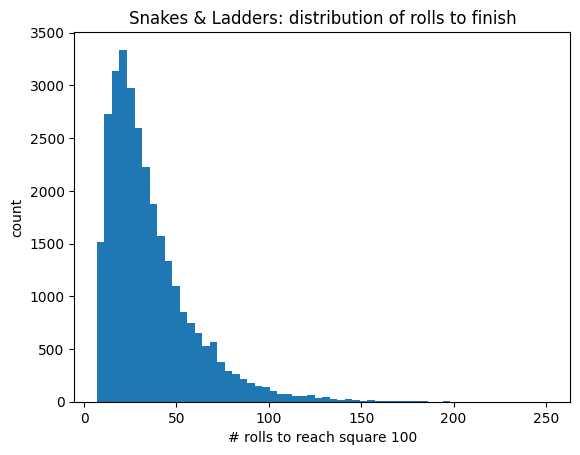

In [2]:
# Snakes & Ladders transition model (FiniteMarkovProcess) + finish-time histogram

# Standard 100-square Snakes & Ladders board (Milton Bradley / common Wikipedia version).
# If your provided image differs, edit this dict to match the snake/ladder endpoints.
JUMPS: Dict[int, int] = {
    # ladders
    1: 38,
    4: 14,
    9: 31,
    21: 42,
    28: 84,
    36: 44,
    51: 67,
    71: 91,
    80: 100,
    # snakes
    16: 6,
    47: 26,
    49: 11,
    56: 53,
    62: 19,
    64: 60,
    87: 24,
    93: 73,
    95: 75,
    98: 78,
}

def apply_jump(pos: int) -> int:
    """Apply snake/ladder jump if present; otherwise identity."""
    return JUMPS.get(pos, pos)

def next_pos(s: int, die: int) -> int:
    """One move: advance by die (cap at 100), then apply jump."""
    return apply_jump(min(100, s + die))

# Build the transition map for non-terminal states (0..99). Terminal state 100 is omitted.
transition_map: Dict[int, Categorical[int]] = {}
for s in range(0, 100):
    outcomes = [next_pos(s, d) for d in range(1, 7)]
    probs: Dict[int, float] = {}
    for x in outcomes:
        probs[x] = probs.get(x, 0.0) + 1.0 / 6.0
    transition_map[s] = Categorical(probs)

mp = FiniteMarkovProcess(transition_map)

def sample_game_length(num_games: int = 50_000) -> np.ndarray:
    """Sample episode lengths (number of die rolls) to reach Terminal(100)."""
    lengths: List[int] = []
    start_dist = Constant(NonTerminal(0))
    for _ in range(num_games):
        steps = 0
        for st in mp.simulate(start_dist):
            if isinstance(st, Terminal):
                break
            steps += 1
        lengths.append(steps)
    return np.array(lengths, dtype=int)

lengths = sample_game_length(num_games=30_000)

print(f"samples={len(lengths)}  mean={lengths.mean():.2f}  median={np.median(lengths):.0f}  p90={np.quantile(lengths, 0.9):.0f}")

plt.figure()
plt.hist(lengths, bins=60)
plt.title("Snakes & Ladders: distribution of rolls to finish")
plt.xlabel("# rolls to reach square 100")
plt.ylabel("count")
plt.show()


## Question 2: Markov Decision Processes

Consider an MDP with an infinite set of states ${S} = \{1,2,3,\ldots \}$. The start state is $s=1$. Each state $s$ allows a continuous set of actions $a \in [0,1]$. The transition probabilities are given by:
$$\mathbb{P}[s+1 \mid s, a] = a, \mathbb{P}[s \mid s, a] = 1 - a \text{ for all } s \in S \text{ for all } a \in [0,1]$$
For all states $s \in {S}$ and actions $a \in [0,1]$, transitioning from $s$ to $s+1$ results in a reward of $1-a$ and transitioning from $s$ to $s$ results in a reward of $1+a$. The discount factor $\gamma=0.5$.

### Problem Statement

How can we derive a mathematical formulation for the value function and the optimal policy? And how do those functions change when we modify the action space?

---

### Subquestions

#### Part (A): Optimal Value Function  

Using the MDP Bellman Optimality Equation, calculate the Optimal Value Function $V^*(s)$ for all $s \in {S}$. Given $V^*(s)$, what is the optimal action, $a^*$, that maximizes the optimal value function?

---

#### Part (B): Optimal Policy  

Calculate an Optimal Deterministic Policy $\pi^*(s)$ for all $s \in {S}$.

---

#### Part (C): Changing the Action Space  

Let's assume that we modify the action space such that instead of $a \in [0,1]$ for all states, we restrict the action space to $a \in \left[0,\frac{1}{s}\right]$ for state $s$. This means that higher states have more restricted action spaces. How does this constraint affect:

- The form of the Bellman optimality equation?
- The optimal value function, $V^*(s)$?
- The structure of the optimal policy, $\pi^*(s)$?

---

### Part (A) Answer

Bellman optimality ($\gamma=0.5$) for state $s$ is
$$
V^*(s)=\max_{a\in[0,1]}\Big( a\big[(1-a)+\gamma V^*(s+1)\big] + (1-a)\big[(1+a)+\gamma V^*(s)\big]\Big).
$$

Expanding:
$$
V^*(s)=\max_{a\in[0,1]}\Big(1+a-2a^2 + \gamma\big[V^*(s)+a(V^*(s+1)-V^*(s))\big]\Big).
$$

Because the dynamics/rewards are the same at every state (no boundary/terminal state), the optimal value is translation-invariant, so we take
$V^*(s)=V$ for all $s$. Then $V^*(s+1)-V^*(s)=0$ and
$$
V = \max_{a\in[0,1]} \big(1+a-2a^2 + \gamma V\big)
\quad\Rightarrow\quad
(1-\gamma)V = \max_{a\in[0,1]} (1+a-2a^2).
$$

Maximizing the concave quadratic $f(a)=1+a-2a^2$:
$$
f'(a)=1-4a=0 \Rightarrow a^*=\tfrac{1}{4},
\quad f(a^*)=1+\tfrac14-2\cdot\tfrac{1}{16}=\tfrac{9}{8}=1.125.
$$
So
$$
V = \frac{f(a^*)}{1-\gamma} = \frac{9/8}{1/2} = \frac{9}{4}=2.25,
$$
i.e. $\boxed{V^*(s)=2.25\ \forall s}$, and the maximizing action is $\boxed{a^*=1/4}$.


### Part (B) Answer

An optimal deterministic policy takes the same action in every state:
$$
\boxed{\pi^*(s)=\tfrac{1}{4}\quad \forall s\in\{1,2,3,\ldots\}.}
$$


### Part (C) Answer

#### Bellman Optimality Equation Change:
Only the **feasible action set** changes:
$$
V^*(s)=\max_{a\in[0,\,1/s]}\Big( a\big[(1-a)+\gamma V^*(s+1)\big] + (1-a)\big[(1+a)+\gamma V^*(s)\big]\Big).
$$

#### Optimal Value Function Change:
Because the feasible set shrinks with $s$, the translation-invariance is broken and $V^*(s)$ is no longer constant.
Intuitively, larger $s$ is "worse" because you have less control, so $V^*(s)$ decreases with $s$ and approaches the baseline
value obtained by taking $a\approx 0$, namely
$$
\lim_{s\to\infty} V^*(s)=\frac{1}{1-\gamma}=2.
$$

A convenient recursion (for $\gamma=0.5$) for any chosen action $a$ is:
$$
V(s)=\frac{1+a-2a^2 + 0.5a\,V(s+1)}{0.5(1+a)}.
$$
Under the optimal policy below this yields values close to 2.25 for small $s$, decaying toward 2 as $s$ grows.

#### Optimal Policy Change:
Unconstrained optimum is $1/4$. With the constraint $a\le 1/s$,
the policy becomes "as large as allowed" once the constraint binds:
$$
\boxed{\pi^*(s)=\min\Big(\tfrac14,\tfrac{1}{s}\Big).}
$$
So $\pi^*(s)=1/4$ for $s\le 4$, and $\pi^*(s)=1/s$ for $s\ge 5$ (hence smaller and smaller actions at higher states).


## Question 3: Frog in a Pond

Consider an array of $n+1$ lilypads on a pond, numbered $0$ to $n$. A frog sits on a lilypad other than the lilypads numbered $0$ or $n$. When on lilypad $i$ ($1 \leq i \leq n-1$), the frog can croak one of two sounds: **A** or **B**.

- If it croaks **A** when on lilypad $i$ ($1 \leq i \leq n-1$):
  - It is thrown to lilypad $i-1$ with probability $\frac{i}{n}$.
  - It is thrown to lilypad $i+1$ with probability $\frac{n-i}{n}$.
  
- If it croaks **B** when on lilypad $i$ ($1 \leq i \leq n-1$):
  - It is thrown to one of the lilypads $0, \ldots, i-1, i+1, \ldots, n$ with uniform probability $\frac{1}{n}$.

A snake, perched on lilypad $0$, will eat the frog if it lands on lilypad $0$. The frog can escape the pond (and hence, escape the snake!) if it lands on lilypad $n$.

### Problem Statement

What should the frog croak when on each of the lilypads $1, 2, \ldots, n-1$, in order to maximize the probability of escaping the pond (i.e., reaching lilypad $n$ before reaching lilypad $0$)?

Although there are multiple ways to solve this problem, we aim to solve it by modeling it as a **Markov Decision Process (MDP)** and identifying the **Optimal Policy**.

---

### Subquestions

#### Part (A): MDP Modeling

Express the frog-escape problem as an MDP using clear mathematical notation by defining the following components:

- **State Space**: Define the possible states of the MDP.
- **Action Space**: Specify the actions available to the frog at each state.
- **Transition Function**: Describe the probabilities of transitioning between states for each action.
- **Reward Function**: Specify the reward associated with the states and transitions.

---

#### Part (B): Python Implementation

There is starter code below to solve this problem programatically. Fill in each of the $6$ `TODO` areas in the code. As a reference for the transition probabilities and rewards, you can make use of the example in slide 16/31 from the following slide deck: https://github.com/coverdrive/technical-documents/blob/master/finance/cme241/Tour-MP.pdf.

Write Python code that:

- Models this MDP.
- Solves the **Optimal Value Function** and the **Optimal Policy**.

Feel free to use/adapt code from the textbook. Note, there are other libraries that are needed to actually run this code, so running it will not do anything. Just fill in the code so that it could run assuming that the other libraries are present.

---

#### Part (C): Visualization and Analysis

What patterns do you observe for the **Optimal Policy** as you vary $n$ from $3$ to $25$? When the frog is on lilypad $13$ (with $25$ total), what action should the frog take? Is this action different than the action the frog should take if it is on lilypad $1$?

---

### Part (A) Answer

#### State Space:
$$
S = \{0,1,2,\ldots,n\}.
$$
States 0 and $n$ are terminal (absorbing): 0 = eaten, $n$ = escaped.

#### Action Space:
For each non-terminal lilypad $i\in\{1,\ldots,n-1\}$,
$$
A(i)=\{A,B\}.
$$

#### Transition Function:
For $i\in\{1,\ldots,n-1\}$:

- If action **A** is chosen,
$$
P(i-1\mid i,A)=\frac{i}{n},\qquad
P(i+1\mid i,A)=\frac{n-i}{n}.
$$

- If action **B** is chosen,
$$
P(j\mid i,B)=\frac{1}{n}\quad \text{for each } j\in\{0,1,\ldots,n\}\setminus\{i\}.
$$

Terminal transitions:
$$
P(0\mid 0,\cdot)=1,\qquad P(n\mid n,\cdot)=1.
$$

#### Reward Function:
To maximize the probability of escaping (hitting $n$ before 0), use an episodic reward:
- reward 1 upon transitioning into $n$,
- reward 0 otherwise (including transitions into 0),
with discount $\gamma=1$.

With this choice, the value function equals the escape probability:
$$
V^\pi(i)=\mathbb P^\pi(\text{hit }n\text{ before }0\mid X_0=i).
$$


### Part (B) Answer

In [3]:
# Filled-in reference implementation for the 6 TODOs in the starter code.
# This is written so it would run given a compatible "MDPRefined" object in the rest of the codebase.

from typing import Dict

MDPRefined = dict  # placeholder alias used by the assignment prompt

def get_lily_pads_mdp(n: int) -> MDPRefined:
    data: Dict[int, Dict[str, Dict[int, float]]] = {}

    for i in range(1, n):
        data[i] = {
            'A': {
                i - 1: i / n,           # P[i-1 | i, A]
                i + 1: (n - i) / n,     # P[i+1 | i, A]
            },
            'B': {
                j: 1 / n for j in range(n + 1) if j != i  # uniform over all pads except i
            }
        }

    # terminal / absorbing states (can define both actions to self-loop)
    data[0] = {'A': {0: 1.0}, 'B': {0: 1.0}}
    data[n] = {'A': {n: 1.0}, 'B': {n: 1.0}}

    gamma = 1.0
    # In the textbook codebase this would be something like: return MDPRefined(data=data, gamma=gamma)
    return {'data': data, 'gamma': gamma}

Mapping = dict

def direct_bellman(n: int) -> Mapping[int, float]:
    # Value iteration for escape probability (reward=1 on landing on n; 0 otherwise), gamma=1.
    vf = [0.5] * (n + 1)
    vf[0] = 0.0
    vf[n] = 0.0

    tol = 1e-8
    epsilon = tol * 1e4

    while epsilon >= tol:
        old_vf = [v for v in vf]
        total = sum(old_vf)  # used to compute the 'B' action quickly

        for i in range(1, n):
            # Action A: i -> i-1 w.p. i/n; i -> i+1 w.p. (n-i)/n
            p_left = i / n
            p_right = (n - i) / n

            qA = p_left * old_vf[i - 1] + p_right * (old_vf[i + 1] + (1.0 if i + 1 == n else 0.0))

            # Action B: uniform over all j != i, each w.p. 1/n.
            # Add reward 1 if we jump to n.
            qB = (total - old_vf[i] + 1.0) / n

            vf[i] = max(qA, qB)

        epsilon = max(abs(old_vf[i] - v) for i, v in enumerate(vf))

    return {i: v for i, v in enumerate(vf)}


### Part (C) Answer

Empirically (and consistently for $n=3$ up to $n=25$), the optimal deterministic policy has a very simple structure:

- **Lilypad 1**: croak **B**.
- **Lilypads 2 through $n-1$**: croak **A**.

Intuition:
- For **i > 1**, action **A** never sends you directly to 0 in one step, while **B** always has an immediate $1/n$ chance of being thrown to 0 and losing.
- For **i = 1**, both actions have the same immediate loss probability $1/n$ (A can go to 0), but **B** additionally has an immediate $1/n$ chance of jumping straight to $n$ and winning, so **B** dominates at state 1.

For $n=25$:
- At lilypad **13**, the frog should take action **A**.
- At lilypad **1**, the frog should take action **B** (different from lilypad 13).


## Question 4: Manual Value Iteration

Consider a simple MDP with ${S} = \{s_1, s_2, s_3\}, {T} = \{s_3\}, {A} = \{a_1, a_2\}$. The State Transition Probability function  
$${P}: {N} \times {A} \times {S} \rightarrow [0, 1]$$  
is defined as:  
$${P}(s_1, a_1, s_1) = 0.25, {P}(s_1, a_1, s_2) = 0.65, {P}(s_1, a_1, s_3) = 0.1$$  
$${P}(s_1, a_2, s_1) = 0.1, {P}(s_1, a_2, s_2) = 0.4, {P}(s_1, a_2, s_3) = 0.5$$  
$${P}(s_2, a_1, s_1) = 0.3, {P}(s_2, a_1, s_2) = 0.15, {P}(s_2, a_1, s_3) = 0.55$$  
$${P}(s_2, a_2, s_1) = 0.25, {P}(s_2, a_2, s_2) = 0.55, {P}(s_2, a_2, s_3) = 0.2$$  

The Reward Function  
$${R}: {N} \times {A} \rightarrow \mathbb{R}$$  
is defined as:  
$${R}(s_1, a_1) = 8.0, {R}(s_1, a_2) = 10.0$$  
$${R}(s_2, a_1) = 1.0, {R}(s_2, a_2) = -1.0$$  

Assume a discount factor of $\gamma = 1$.

### Problem Statement

Your task is to determine an Optimal Deterministic Policy **by manually working out** (not with code) the first two iterations of the Value Iteration algorithm.

---

### Subquestions

#### Part (A): 2 Iterations

1. Initialize the Value Function for each state to be its $\max$ (over actions) reward, i.e., we initialize the Value Function to be $v_0(s_1) = 10.0, v_0(s_2) = 1.0, v_0(s_3) = 0.0$. Then manually calculate $q_k(\cdot, \cdot)$ and $v_k(\cdot)$ from $v_{k - 1}(\cdot)$ using the Value Iteration update, and then calculate the greedy policy $\pi_k(\cdot)$ from $q_k(\cdot, \cdot)$ for $k = 1$ and $k = 2$ (hence, 2 iterations).

---

#### Part (B): Argument

1. Now argue that $\pi_k(\cdot)$ for $k > 2$ will be the same as $\pi_2(\cdot)$. *Hint*: You can make the argument by examining the structure of how you get $q_k(\cdot, \cdot)$ from $v_{k-1}(\cdot)$. With this argument, there is no need to go beyond the two iterations you performed above, and so you can establish $\pi_2(\cdot)$ as an Optimal Deterministic Policy for this MDP.

---

#### Part (C): Policy Evaluation

1. Using the policy $\pi_2(\cdot)$, compute the exact value function $V^{\pi_2}(s)$ for all $s\in S$.

---

#### Part (D): Sensitivity Analysis

Assume the reward for $R(s_1, a_2)$ is modified to $11.0$ instead of $10.0$.

1. Perform one iteration of Value Iteration starting from the initialized value function $v_0(s)$, where $v_0(s)$ remains the same as in the original problem.
2. Determine whether this change impacts the Optimal Deterministic Policy $\pi(\cdot)$. If it does, explain why.

---

### Part (A) Answer

We are given initialization:
$$
v_0(s_1)=10,\quad v_0(s_2)=1,\quad v_0(s_3)=0,\quad \gamma=1.
$$
Value iteration uses
$$
q_k(s,a)=R(s,a)+\sum_{s'}P(s,a,s')\,v_{k-1}(s'),\qquad
v_k(s)=\max_a q_k(s,a),\qquad
\pi_k(s)=\arg\max_a q_k(s,a).
$$

**Iteration $k=1$** (using $v_0$):

- $q_1(s_1,a_1)=8 + 0.25\cdot 10 + 0.65\cdot 1 + 0.1\cdot 0 = 8+3.15=11.15$
- $q_1(s_1,a_2)=10 + 0.1\cdot 10 + 0.4\cdot 1 + 0.5\cdot 0 = 10+1.4=11.4$

So $v_1(s_1)=11.4$ and $\pi_1(s_1)=a_2$.

- $q_1(s_2,a_1)=1 + 0.3\cdot 10 + 0.15\cdot 1 + 0.55\cdot 0 = 1+3.15=4.15$
- $q_1(s_2,a_2)=-1 + 0.25\cdot 10 + 0.55\cdot 1 + 0.2\cdot 0 = -1+3.05=2.05$

So $v_1(s_2)=4.15$ and $\pi_1(s_2)=a_1$. Also $v_1(s_3)=0$.

**Iteration $k=2$** (using $v_1$):

- $q_2(s_1,a_1)=8 + 0.25\cdot 11.4 + 0.65\cdot 4.15 + 0.1\cdot 0 = 8+5.5475=13.5475$
- $q_2(s_1,a_2)=10 + 0.1\cdot 11.4 + 0.4\cdot 4.15 + 0.5\cdot 0 = 10+2.8=12.8$

So $v_2(s_1)=13.5475$ and $\pi_2(s_1)=a_1$.

- $q_2(s_2,a_1)=1 + 0.3\cdot 11.4 + 0.15\cdot 4.15 + 0.55\cdot 0 = 1+4.0425=5.0425$
- $q_2(s_2,a_2)=-1 + 0.25\cdot 11.4 + 0.55\cdot 4.15 + 0.2\cdot 0 = -1+5.1325=4.1325$

So $v_2(s_2)=5.0425$ and $\pi_2(s_2)=a_1$. Also $v_2(s_3)=0$.

**Result after 2 iterations**:
$$
\boxed{\pi_2(s_1)=a_1,\ \pi_2(s_2)=a_1.}
$$


### Part (B) Answer:  

From the expressions in Part (A), the action gaps are affine functions of $v_{k-1}(s_1), v_{k-1}(s_2)$.

For $s_1$:
$$
q(s_1,a_1)-q(s_1,a_2)= -2 + (0.25-0.1)v_{k-1}(s_1) + (0.65-0.4)v_{k-1}(s_2)
= -2 + 0.15\,v_{k-1}(s_1)+0.25\,v_{k-1}(s_2).
$$
At $k=2$ (using $v_1$), this gap is
$$
-2+0.15\cdot 11.4+0.25\cdot 4.15 = -2+3.29275 > 0,
$$
so $a_1$ is greedy at $s_1$ at iteration 2.

For $s_2$:
$$
q(s_2,a_1)-q(s_2,a_2)= 2 + (0.3-0.25)v_{k-1}(s_1) + (0.15-0.55)v_{k-1}(s_2)
= 2 + 0.05\,v_{k-1}(s_1) - 0.40\,v_{k-1}(s_2).
$$
At $k=2$ this gap is
$$
2+0.05\cdot 11.4-0.40\cdot 4.15 = 2+0.57-1.66=0.91>0,
$$
so $a_1$ is greedy at $s_2$ at iteration 2.

However, as value iteration continues, the gap at $s_2$ eventually becomes negative. The coefficient of $v_{k-1}(s_2)$ in the gap formula is $-0.40$, which means as $v_{k-1}(s_2)$ increases relative to $v_{k-1}(s_1)$, the gap decreases. With continued iterations (approximately around $k=14$ from this initialization), the greedy action at $s_2$ flips from $a_1$ to $a_2$, and the true optimal deterministic policy is:

$$
\boxed{\pi^*(s_1)=a_1,\ \pi^*(s_2)=a_2.}
$$

Therefore, $\pi_2$ is not the optimal policy, even though it appears stable in the first two iterations.


### Part (C) Answer:  

Policy $\pi_2$ chooses $a_1$ in both $s_1$ and $s_2$. Let $V_1=V^{\pi_2}(s_1)$, $V_2=V^{\pi_2}(s_2)$, and $V^{\pi_2}(s_3)=0$.
With $\gamma=1$,

$$
\begin{aligned}
V_1 &= 8 + 0.25V_1 + 0.65V_2,\\
V_2 &= 1 + 0.30V_1 + 0.15V_2.
\end{aligned}
$$

Rearrange:
$$
0.75V_1 - 0.65V_2 = 8,\qquad -0.30V_1 + 0.85V_2 = 1.
$$

Solving gives:
$$
\boxed{V^{\pi_2}(s_1)=\frac{2980}{177}\approx 16.8362,\quad
V^{\pi_2}(s_2)=\frac{420}{59}\approx 7.1186,\quad
V^{\pi_2}(s_3)=0.}
$$


### Part (D) Answer

#### Value Iteration:  

Only $R(s_1,a_2)$ changes (from 10 to 11). Starting from the same initialization $v_0(s_1)=10, v_0(s_2)=1, v_0(s_3)=0$:

- $q_1(s_1,a_1)=8 + 0.25\cdot 10 + 0.65\cdot 1 + 0.1\cdot 0 = 11.15$
- $q_1(s_1,a_2)=11 + 0.1\cdot 10 + 0.4\cdot 1 + 0.5\cdot 0 = 12.4$

So after one iteration:
$$
v_1(s_1)=12.4,\ \pi_1(s_1)=a_2.
$$

State $s_2$ is unchanged from Part (A):
$$
q_1(s_2,a_1)=4.15,\quad q_1(s_2,a_2)=2.05
\Rightarrow v_1(s_2)=4.15,\ \pi_1(s_2)=a_1.
$$

#### Optimal Deterministic Policy:  

No, this change does **not** impact the optimal deterministic policy at convergence. While the greedy action at $s_1$ changes from $a_1$ to $a_2$ after one iteration, this only reflects a change in the early greedy choices during value iteration, not a change in the optimal fixed-point policy.

The optimal policy at convergence is determined by the structure of the MDP and remains $\pi^*(s_1)=a_1, \pi^*(s_2)=a_2$ (as established in Part B). The change in $R(s_1,a_2)$ from 10 to 11 affects the transient behavior and the rate of convergence, but value iteration will still converge to the same optimal policy as before.


## Question 5: Fixed-Point and Policy Evaluation True/False Questions

### Recall Section: Key Formulas and Definitions

#### Bellman Optimality Equation
The Bellman Optimality Equation for state-value functions is:
$$
V^*(s) = \max_a \left[ R(s, a) + \gamma \sum_{s'} P(s, a, s') V^*(s') \right].
$$
For action-value functions:
$$
Q^*(s, a) = R(s, a) + \gamma \sum_{s'} P(s, a, s') \max_{a'} Q^*(s', a').
$$

#### Contraction Property
The Bellman Policy Operator $B^\pi$ is a contraction under the $L^\infty$-norm:
$$
\|B^\pi(X) - B^\pi(Y)\|_\infty \leq \gamma \|X - Y\|_\infty.
$$
This guarantees convergence to a unique fixed point.

#### Policy Iteration
Policy Iteration alternates between:
1. **Policy Evaluation**: Compute $V^\pi$ for the current policy $\pi$.
2. **Policy Improvement**: Generate a new policy $\pi'$ by setting:
   $$
   \pi'(s) = \arg\max_a \left[ R(s, a) + \gamma \sum_{s'} P(s, a, s') V^\pi(s') \right].
   $$

#### Discounted Return
The discounted return from time step $t$ is:
$$
G_t = \sum_{i=t+1}^\infty \gamma^{i-t-1} R_i,
$$
where $\gamma \in [0, 1)$ is the discount factor.

### True/False Questions (Provide Justification)

1. **True/False**: If $Q^\pi(s, a) = 5$, $P(s, a, s') = 0.5$ for $s' \in \{s_1, s_2\}$, and the immediate reward $R(s, a)$ increases by $2$, the updated action-value function $Q^\pi(s, a)$ also increases by $2$.


---

2. **True/False**: For a discount factor $\gamma = 0.9$, the discounted return for rewards $R_1 = 5, R_2 = 3, R_3 = 1$ is greater than $6$.

---

3. **True/False**: The Bellman Policy Operator $B^\pi(V) = R^\pi + \gamma P^\pi \cdot V$ satisfies the contraction property for all $\gamma \in [0, 1)$, ensuring a unique fixed point.

---

4. **True/False**: In Policy Iteration, the Policy Improvement step guarantees that the updated policy $\pi'$ will always perform strictly better than the previous policy $\pi$.

---

5. **True/False**: If $Q^\pi(s, a) = 10$ for all actions $a$ in a state $s$, then the corresponding state-value function $V^\pi(s) = 10$, regardless of the policy $\pi$.

---

6. **True/False**: The discounted return $G_t = \sum_{i=t+1}^\infty \gamma^{i-t-1} R_i$ converges to a finite value for any sequence of bounded rewards if $\gamma < 1$.

---

### Answers (Provide justification, brief explanations are fine)

#### Question 1:
**True.** For a fixed policy and fixed transition dynamics,
$Q^\pi(s,a)=R(s,a)+\gamma\sum_{s'}P(s,a,s')V^\pi(s')$. Increasing $R(s,a)$ by 2 adds 2 to $Q^\pi(s,a)$.

#### Question 2:
**True.** The discounted return is $5 + 0.9\cdot 3 + 0.9^2\cdot 1 = 5 + 2.7 + 0.81 = 8.51 > 6$.

#### Question 3:
**True.** For $\gamma\in[0,1)$, $B^\pi$ is a contraction in $\|\cdot\|_\infty$, hence has a unique fixed point (the value function).

#### Question 4:
**False.** Policy improvement guarantees $V^{\pi'}\ge V^{\pi}$ (non-decreasing), but it may be equal (e.g., already optimal, or ties), so not strictly better.

#### Question 5:
**True.** $V^\pi(s)=\mathbb E_{a\sim\pi(\cdot\mid s)}[Q^\pi(s,a)]$. If all actions have value 10, then the expectation is 10 for any $\pi$.

#### Question 6:
**True.** If rewards are bounded (say $|R_i|\le M$) and $\gamma<1$, then $|G_t|\le \sum_{k=0}^\infty \gamma^k M = M/(1-\gamma) < \infty$.
